# Importing Census Data

In [1]:
import requests
import pandas as pd
import numpy as np
from census import Census
from api_keys_ml import api_key
import matplotlib.pyplot as plt
from scipy import stats
from unidecode import unidecode
from sklearn.linear_model import LinearRegression
import re


In [2]:

#Years to loop through 
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]  # You can add more years here
dsource = 'acs'
dname = 'acs1'
# Data columns to fetch
cols = 'NAME,B25077_001E,B25058_001E,B15003_022E,B01003_001E,B23025_004E,B17001_002E,B23025_003E,B19013_001E'  
# List of all state FIPS codes

state_fips_codes = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '72']  

# Initialize an empty DataFrame to collect data
all_data = []

# Loop through each year
for year in years:
    
    # Loop through all states to fetch data for all counties
    for state in state_fips_codes:
        # Construct the data URL for querying each state and its counties for the current year
        data_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}?get={cols}&for=county:*&in=state:{state}&key={api_key}'

        # Send the GET request to the Census API
        response = requests.get(data_url)

        # Check if the request was successful (200 indicates request was successfully processed)
        if response.status_code == 200:
            # Parse the response JSON data
            data = response.json()
            
            # Create a DataFrame from the response data
            df = pd.DataFrame(data[1:], columns=data[0])  # Skip the header row
            
            # Rename columns
            df = df.rename(columns={
                'NAME': 'County Name',
                'state': 'State FIPS',
                'county': 'County FIPS',
                'B25077_001E': 'Median House Price ($)',
                'B25058_001E': 'Median Rent ($)',
                'B01003_001E': 'Total Population',
                'B15003_022E': 'Population with Bachelor\'s Degree',
                'B23025_004E': 'Number of Employed People',
                'B17001_002E': 'People with Income Below Poverty',
                'B23025_003E': 'Total Labor Force',
                'B19013_001E': 'Median Household Income ($)'
            })
            
            # Add a column for the year
            df['Year'] = year
            
            
            
            # Append the data for this year and state to the list
            all_data.append(df)
        else:
            print(f"Error: {response.status_code} for State: {state} in Year: {year}")

# Concatenate all data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)




In [11]:

# Convert columns to numeric, errors='coerce' will turn invalid values into NaN
numeric_columns = [
    'Median House Price ($)', 'Median Rent ($)', 'Total Population',
    'Population with Bachelor\'s Degree', 'Number of Employed People',
    'People with Income Below Poverty', 'Total Labor Force', 'Median Household Income ($)'
]

# Convert all columns to numeric
for col in numeric_columns:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

# Now print the min and max values, ignoring NaNs
print('Minimum Values:')
print(final_df.min())
print('---------------------------------------------------')
print('Maximum Values:')
print(final_df.max())

data_df = final_df.dropna()

# Check for missing values and data types
print('Number of Null Values in Each Column:')
print(data_df.isnull().sum())

# Removes Non-ASCII Characters
data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())
clean_data_df = final_df.dropna()

Minimum Values:
County Name                          Ada County, Idaho
Median House Price ($)                           49400
Median Rent ($)                                    229
Population with Bachelor's Degree               2306.0
Total Population                                 61792
Number of Employed People                        15513
People with Income Below Poverty                1432.0
Total Labor Force                                19658
Median Household Income ($)                      11940
State FIPS                                          01
County FIPS                                        001
Year                                              2011
dtype: object
---------------------------------------------------
Maximum Values:
County Name                          Yuma County, Arizona
Median House Price ($)                            1233600
Median Rent ($)                                      2415
Population with Bachelor's Degree               1551191.0
Total Popu

C:\Users\eddy2\AppData\Local\Temp\ipykernel_18060\2953595969.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())


In [23]:
clean_data_df.to_csv('census_data_all.csv', index=False)

In [24]:
clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
clean_data_df['% People Living in Poverty'] = (clean_data_df['People with Income Below Poverty'] / clean_data_df['Total Population']) * 100
clean_data_df['% Pop. Bachelors Degree'] = clean_data_df['Population with Bachelor\'s Degree'] / clean_data_df['Total Population'] * 100

clean_data_df

C:\Users\eddy2\AppData\Local\Temp\ipykernel_18060\999656447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
C:\Users\eddy2\AppData\Local\Temp\ipykernel_18060\999656447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
C:\Users\eddy2\AppData\Local

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree,Combined FIPS
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,01,003,2011,4.784498,91.068052,12.972038,12.937761,00301
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,01,015,2011,5.037336,87.107572,20.663514,6.579115,01501
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,01,043,2011,4.392857,90.176552,18.302374,6.056919,04301
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,01,049,2011,4.461380,87.818876,18.484063,3.453590,04901
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,01,051,2011,3.860309,89.063651,12.161623,10.402685,05101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,"Toa Baja Municipio, Puerto Rico",111100,478,10751.0,74271,27886,28367.0,31768,23368,72,137,2019,5.162916,87.780156,38.193911,14.475367,13772
7475,"Caguas Municipio, Puerto Rico",124500,463,20932.0,124606,47132,47851.0,52224,24507,72,025,2019,4.462651,90.249694,38.401843,16.798549,02572
7476,"San Juan Municipio, Puerto Rico",151700,438,55716.0,318441,116362,124927.0,141555,23005,72,127,2019,3.464733,82.202677,39.230815,17.496491,12772
7477,"Guaynabo Municipio, Puerto Rico",174700,532,18127.0,83728,35993,19101.0,39237,37499,72,061,2019,3.654264,91.732293,22.813157,21.649866,06172


In [14]:
#GROUPING ALL DATA BY COUNTIES
#To ensure exact matches, we need to group by all State FIPS, County FIPS, and County Name.
#This is because counties in different states may have the same name.
clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']

grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS'])
grouped_df.head()

C:\Users\eddy2\AppData\Local\Temp\ipykernel_18060\500881713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,% Pop. Bachelors Degree,Combined FIPS
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,01,003,2011,4.784498,91.068052,12.972038,12.937761,00301
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,01,015,2011,5.037336,87.107572,20.663514,6.579115,01501
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,01,043,2011,4.392857,90.176552,18.302374,6.056919,04301
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,01,049,2011,4.461380,87.818876,18.484063,3.453590,04901
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,01,051,2011,3.860309,89.063651,12.161623,10.402685,05101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7151,"Franklin County, North Carolina",172700,633,8029.0,69685,33272,6025.0,36169,57099,37,069,2019,4.398379,91.990379,8.646050,11.521848,06937
7197,"Athens County, Ohio",145400,724,6432.0,65327,28943,15275.0,31442,41851,39,009,2019,5.975241,92.052032,23.382369,9.845852,00939
7288,"Kershaw County, South Carolina",146800,545,7227.0,66551,29374,9448.0,30909,55198,45,055,2019,4.455041,95.033809,14.196631,10.859341,05545
7344,"Wise County, Texas",243500,719,5985.0,69984,34650,3662.0,35396,71421,48,497,2019,3.543326,97.892417,5.232625,8.551955,49748


# Correlation Between House Prices and Income

**How strongly are median house prices correlated with median household income?**
The scatter plot shows a positive relationship between Median Household Income and Median House Prices. Areas with higher household incomes generally tend to have higher house prices, which aligns with the expectation that wealthier areas can sustain higher housing market values.


**Do areas with higher household incomes generally have higher house prices?**
Trend: The points are spread upwards as income increases, indicating a positive correlation.
Outliers: There may be some areas where house prices deviate from the general trend, suggesting other influencing factors like location desirability or market conditions.


**Is the relationship between income and house prices linear, or are there diminishing returns (e.g., luxury housing markets)?**
The blue regression line represents the linear relationship between income and house prices.
The data points generally align with the line, indicating a positive correlation where house prices increase as household income rises.
The R² value (indicated in the legend) quantifies how well the line explains the variability in house prices based on income.


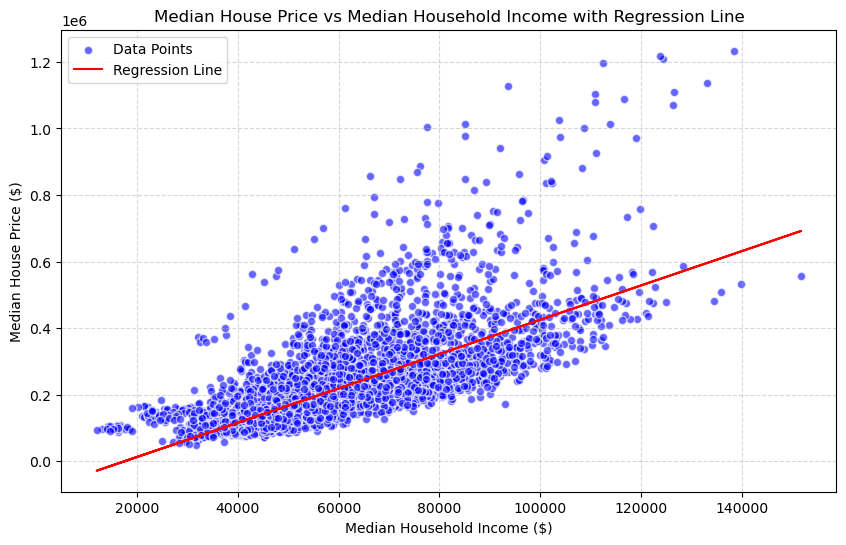

(5.153314356662128, -90380.9689868706)

In [45]:
# with regression
# Prepare data for linear regression
X = data_df['Median Household Income ($)'].values.reshape(-1, 1)
y = data_df['Median House Price ($)'].values

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict values for the regression line
y_pred = model.predict(X)

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(
    data_df['Median Household Income ($)'],
    data_df['Median House Price ($)'],
    alpha=0.6,
    edgecolors='w',
    color='blue',
    label='Data Points'
)
plt.plot(data_df['Median Household Income ($)'], y_pred, color='red', label='Regression Line')
plt.title('Median House Price vs Median Household Income with Regression Line')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Median House Price ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
# Save the figure as an image file
plt.savefig("income_regression_analysis.png", dpi=300, bbox_inches='tight')

plt.show()

# Coefficients of the regression line
model.coef_[0], model.intercept_

The equation for the regression line is:
House Price = 5.15 × Household Income − 90,381

Slope (5.15): For every $1 increase in median household income, the median house price increases by approximately $5.15 on average.
Intercept (-90,381): This represents the estimated house price when household income is $0, though it may not have real-world applicability.


# Impact of Employment Rates on House Prices
Most counties are concentrated in mid-range employment rates and house prices.
Areas with very high house prices and low employment rates are less frequent but noteworthy.

Do regions with higher employment rates also have higher house prices?
There is a weak positive correlation (0.26) between employment rates and house prices, suggesting that regions with higher employment rates tend to have slightly higher house prices. However, the relationship is not strong, indicating that other factors, such as demand driven by external investments or local economic conditions, may also play significant roles.

How does the employment rate influence housing demand and prices over time?
The employment rate can influence housing demand and prices by affecting people's purchasing power and the overall economic stability of a region

Are there areas where high house prices exist despite low employment rates, and what could explain this (e.g., tourism or investment hotspots)?
The heatmap indicates relatively few regions with both low employment rates (below 80%) and high house prices. These regions may exist but are outliers, as the majority of high house prices are clustered with high employment rates.

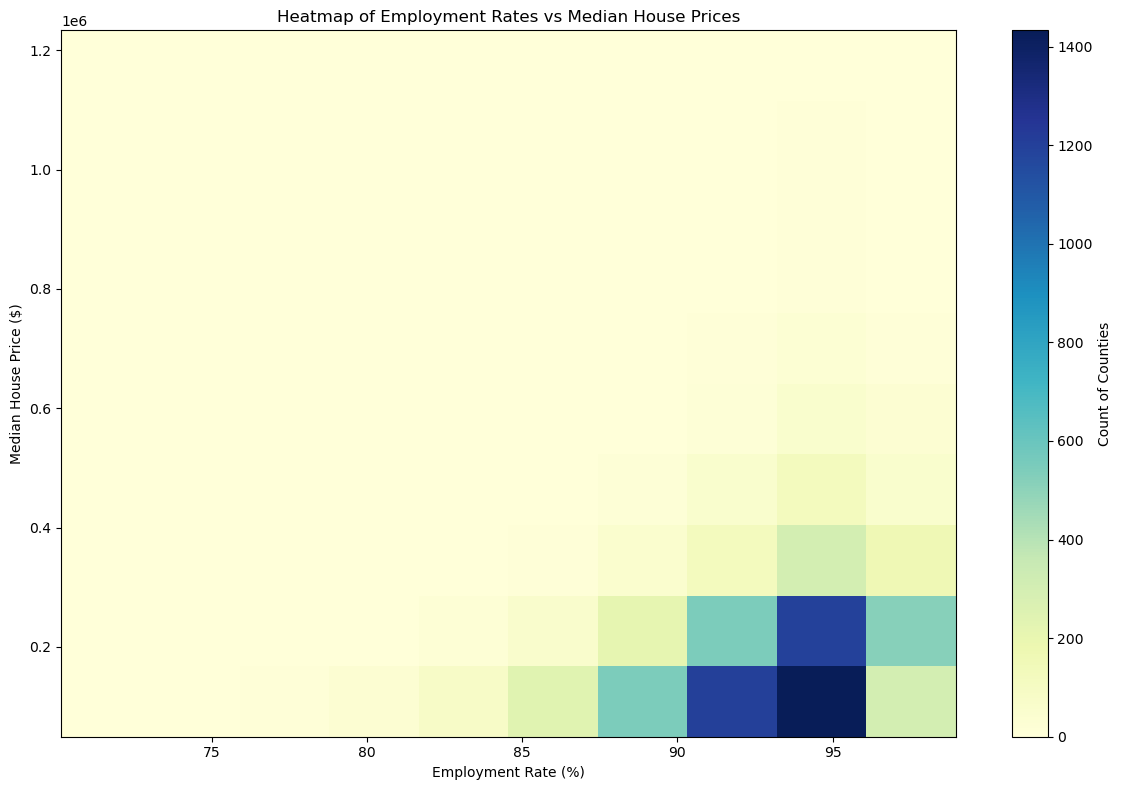

In [46]:
# Ensure data is loaded 
file_path = 'census_data_all.csv' 
census_data = pd.read_csv(file_path)

# Calculate Employment Rate if not already calculated
if 'Employment Rate (%)' not in census_data.columns:
    census_data['Employment Rate (%)'] = (
        (census_data['Number of Employed People'] / census_data['Total Labor Force']) * 100
    )

# Bin the data for employment rate and house price
employment_bins = pd.cut(census_data['Employment Rate (%)'], bins=10, labels=False)
house_price_bins = pd.cut(census_data['Median House Price ($)'], bins=10, labels=False)

# Create a 2D histogram
heatmap_data, xedges, yedges = np.histogram2d(
    census_data['Employment Rate (%)'], 
    census_data['Median House Price ($)'], 
    bins=[10, 10]
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data.T, origin='lower', cmap='YlGnBu', aspect='auto', extent=[
    min(census_data['Employment Rate (%)']),
    max(census_data['Employment Rate (%)']),
    min(census_data['Median House Price ($)']),
    max(census_data['Median House Price ($)']),
])
plt.colorbar(label='Count of Counties')
plt.title('Heatmap of Employment Rates vs Median House Prices')
plt.xlabel('Employment Rate (%)')
plt.ylabel('Median House Price ($)')
plt.tight_layout()
# Save the figure as an image file
plt.savefig("employment_rates_analysis.png", dpi=300, bbox_inches='tight')

plt.show()

The heatmap provides a visual summary of the distribution of counties based on their employment rates and median house prices:

X-axis: Represents binned ranges of median house prices.
Y-axis: Represents binned ranges of employment rates.
Color intensity: Indicates the number of counties within each combination of employment rate and house price bin.

# Temporal Trends
How have median house prices changed relative to median household income and employment rates over time?
Median house prices have generally increased over the years, showing higher growth compared to employment rates.
Median household income growth also shows a steady rise, but at a slightly slower pace than house prices.
Employment rates have improved steadily but show the least percentage growth among the three metrics.

Were there significant shifts in house prices during periods of economic changes (e.g., recessions or booms)?
Periods of economic changes, such as recovery after the 2008-2009 recession, might explain the slower growth in house prices around 2012-2013, with a stronger upward trend from 2014 onwards.

Is the growth rate of house prices outpacing the growth in household income or employment rates?
The growth in house prices outpaces the growth in median household income, indicating potential affordability issues over time. Employment growth, while steady, does not directly correlate with the sharper rise in house prices, suggesting other factors, like housing demand or market pressures, influence prices.

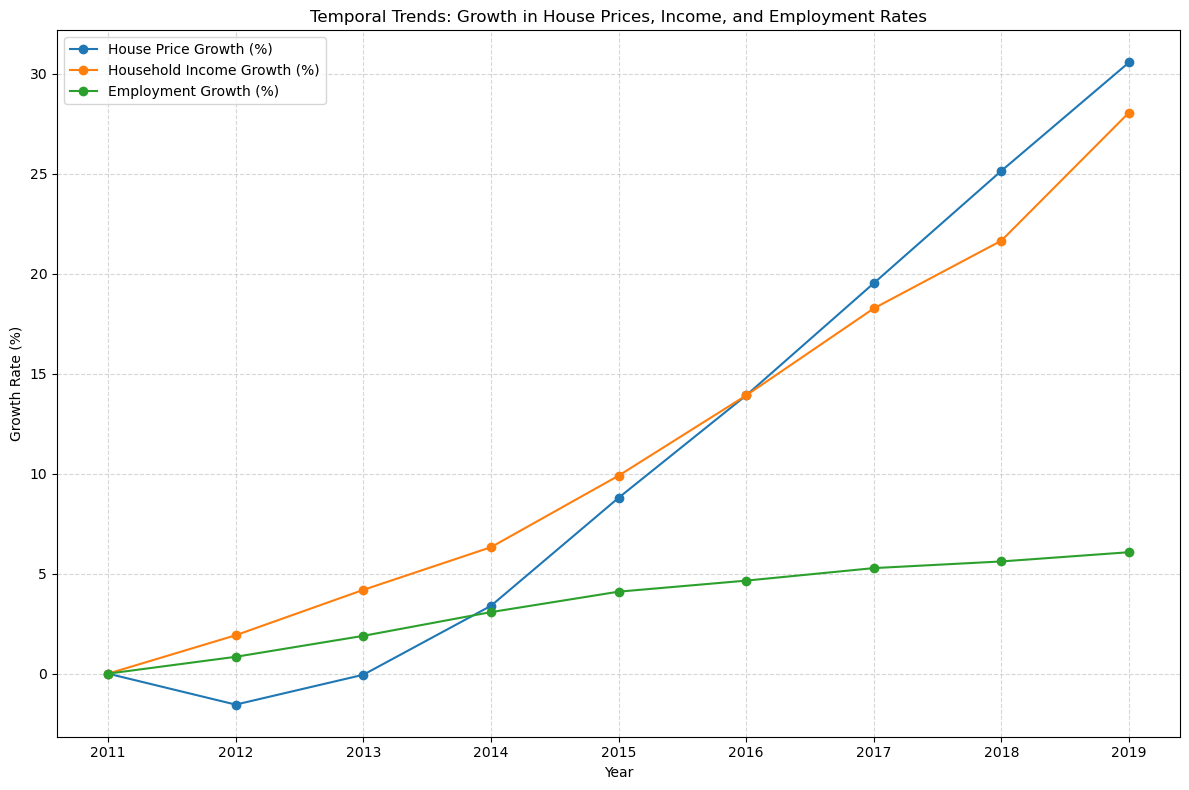

In [47]:
# Group data by year and calculate mean metrics
temporal_data = census_data.groupby('Year').agg({
    'Median House Price ($)': 'mean',
    'Median Household Income ($)': 'mean',
    'Employment Rate (%)': 'mean'
}).reset_index()

# Calculate growth rates relative to the first year for comparison
temporal_data['House Price Growth (%)'] = (
    (temporal_data['Median House Price ($)'] / temporal_data['Median House Price ($)'].iloc[0]) - 1) * 100
temporal_data['Income Growth (%)'] = (
    (temporal_data['Median Household Income ($)'] / temporal_data['Median Household Income ($)'].iloc[0]) - 1) * 100
temporal_data['Employment Growth (%)'] = (
    (temporal_data['Employment Rate (%)'] / temporal_data['Employment Rate (%)'].iloc[0]) - 1) * 100

# Plot temporal trends
plt.figure(figsize=(12, 8))
plt.plot(temporal_data['Year'], temporal_data['House Price Growth (%)'], label='House Price Growth (%)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['Income Growth (%)'], label='Household Income Growth (%)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['Employment Growth (%)'], label='Employment Growth (%)', marker='o')
plt.title('Temporal Trends: Growth in House Prices, Income, and Employment Rates')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# Save the figure as an image file
plt.savefig("temporal_trends_analysis.png", dpi=300, bbox_inches='tight')

plt.show()



The temporal trends analysis visualizes how median house prices, median household income, and employment rates have changed over time. The growth rates are calculated relative to the year 2011.